In [2]:
import matplotlib.pyplot as plt
from pydoc import doc
import re 
import os
from collections import Counter
import pandas as pd
from tqdm import tqdm
import numpy as np
import ast
import torch
from torch.utils.data import Dataset

In [3]:
#change path to big query files as necessary
#nlp server path: 'code-style-probing/data/BigQuery'
manifests = os.listdir('data/BigQuery/files') #data/BigQuery/
manifests = manifests.remove('cubert_metadata000000000000')
print ('list of bigquery files:', manifests)
script_df = pd.read_csv('data/BigQuery/files/cubert_metadata000000000000') 

#smaller test script
#script_df = pd.read_csv('data/BigQuery/files/bq-sample.csv')

#this is for going through all of the csvs for bigquery pull work in progress
'''
for manifest in manifests:
    temp_df = pd.read_csv(f'data/BigQuery/files/{manifest}')
    script_df = pd.concat((script_df, temp_df))
'''


#display (script_df)

list of bigquery files: None


"\nfor manifest in manifests:\n    temp_df = pd.read_csv(f'data/BigQuery/files/{manifest}')\n    script_df = pd.concat((script_df, temp_df))\n"

In [4]:
print(len(script_df))
script_df.head(5)


126663


,id,repository,license,filepath,content,forks,issue_events,stars
0,7efee2302abe88318188446cff57db3374308a1d,jbkalmbach/kbmod,bsd-2-clause,analysis/rawGenerated/batchGenerate.py,from kbmodpy import kbmod as kb\nimport rawSea...,1,32,1
1,e4bf9e1e79620474ce8668253ec256303087918e,pymedusa/SickRage,gpl-3.0,medusa/providers/torrent/rss/rsstorrent.py,"# coding=utf-8\n\n""""""Provider code for RSS Tor...",22,763,27
2,e67032e5fff2307de9e0f92187793914251d9783,ipdata/python,mit,ipdata/test_cli.py,import multiprocessing\nimport sys\nimport uni...,6,15,16
3,7c14c480a61dd134e02364f763a6aa57cc0c9126,demisto/content,mit,Packs/AnsibleLinux/Integrations/AnsibleACME/An...,import traceback\nimport ssh_agent_setup\nimpo...,1328,52,797
4,d7e0bb47b97770961a2436bdded35e8bb1e9b5ab,hidat/audio_pipeline,mit,review_parser/mb_release.py,import json\nimport os\nimport os.path as path...,1,26,4


In [5]:
from lib2to3.refactor import RefactoringTool, get_fixers_from_package
def func_2to3(py2_code):
    refactoring_tool = RefactoringTool(fixer_names=get_fixers_from_package('lib2to3.fixes'))
    py3_node = refactoring_tool.refactor_string(py2_code, 'script')
    return str(py3_node)

In [6]:
#run metrics
from extract_metrics import extract_metrics, metric_dict_to_df
from tqdm import tqdm
script_count = len(script_df['filepath'])
filenames = script_df['filepath']
scripts = script_df['content']
internal_metrics = pd.DataFrame()
parse_error = []
metric_dicts = []
for i in tqdm(range (0, script_count)):
    filename = filenames[i]
    script = scripts[i]

    try:
        script_ast = ast.parse(script)
        metrics = extract_metrics(script, script_ast)
        metric_dicts.append(metrics)
        parse_error.append(1)
        #metric_df = metric_dict_to_df([metrics])
    except:
    # try:
    #     convert_script = func_2to3(script)
    #     script_ast = ast.parse(convert_script)
    # except:
        metric_dicts.append({})
        parse_error.append(0)
    #internal_metrics = internal_metrics.append( metric_df)
metric_df = pd.DataFrame.from_records(metric_dicts)
script_df['parse_error'] = parse_error
display(metric_df)
#print (metric_dicts[0])

100%|██████████| 126663/126663 [08:34<00:00, 245.98it/s]


,line_count,comment_count,comment_avg_len,comment_density,id_total,lower_case,id_total_var,lower_case_var,snake_case,snake_case_var,...,lower_case_method,other_case_class,func_async_count,lower_case_class,snake_case_class,upper_camel_case_method,other_case_method,upper_case_class,lower_camel_case_class,upper_case_method
0,51.0,0.0,0.000000,0.000000,29.0,23.0,29.0,23.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,170.0,8.0,17.625000,0.047059,134.0,89.0,124.0,89.0,34.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,135.0,34.0,37.352941,0.251852,137.0,101.0,130.0,101.0,26.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59.0,11.0,26.818182,0.186441,56.0,25.0,55.0,24.0,30.0,30.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,76.0,12.0,37.166667,0.157895,99.0,64.0,92.0,64.0,2.0,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126658,1292.0,201.0,38.950249,0.155573,1658.0,1533.0,1646.0,1527.0,94.0,88.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126659,194.0,17.0,37.235294,0.087629,63.0,42.0,57.0,41.0,8.0,5.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126660,145.0,1.0,23.000000,0.006897,111.0,76.0,99.0,76.0,30.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126661,48.0,0.0,0.000000,0.000000,53.0,44.0,47.0,44.0,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# add internal metrics to df and filter out parse errors
reset_internal_metrics = internal_metrics.reset_index(drop=True)
metrics_df = pd.concat([script_df, metric_df], axis = 1)
#metrics_df['error'] = parse_error

clean_metrics_df = metrics_df[metrics_df['parse_error'] == 1]
display(clean_metrics_df)


,id,repository,license,filepath,content,forks,issue_events,stars,parse_error,line_count,...,lower_case_method,other_case_class,func_async_count,lower_case_class,snake_case_class,upper_camel_case_method,other_case_method,upper_case_class,lower_camel_case_class,upper_case_method
0,7efee2302abe88318188446cff57db3374308a1d,jbkalmbach/kbmod,bsd-2-clause,analysis/rawGenerated/batchGenerate.py,from kbmodpy import kbmod as kb\nimport rawSea...,1,32,1,1,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e4bf9e1e79620474ce8668253ec256303087918e,pymedusa/SickRage,gpl-3.0,medusa/providers/torrent/rss/rsstorrent.py,"# coding=utf-8\n\n""""""Provider code for RSS Tor...",22,763,27,1,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e67032e5fff2307de9e0f92187793914251d9783,ipdata/python,mit,ipdata/test_cli.py,import multiprocessing\nimport sys\nimport uni...,6,15,16,1,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7c14c480a61dd134e02364f763a6aa57cc0c9126,demisto/content,mit,Packs/AnsibleLinux/Integrations/AnsibleACME/An...,import traceback\nimport ssh_agent_setup\nimpo...,1328,52,797,1,59.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d7e0bb47b97770961a2436bdded35e8bb1e9b5ab,hidat/audio_pipeline,mit,review_parser/mb_release.py,import json\nimport os\nimport os.path as path...,1,26,4,1,76.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126658,49912608b288337ba2a4a18c247c1104faa2a5de,oscarbranson/latools,mit,latools/helpers/plot.py,"""""""\nPlotting functions.\n\n(c) Oscar Branson ...",11,77,9,1,1292.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126659,289a01aba96436c4459b965a1de7544ad5dc311d,erjac77/ansible-module-f5bigip,apache-2.0,library/f5bigip_ltm_monitor_snmp_dca.py,#!/usr/bin/python\n# -*- coding: utf-8 -*-\n#\...,5,72,6,1,194.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126660,e3274c379b0db385868537bddf79a9014e72f0fe,python-hyper/hyper-h2,mit,test/test_config.py,"# -*- coding: utf-8 -*-\n""""""\ntest_config\n~~~...",139,376,754,1,145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126661,73ca68865447b1b8df1c5fca3537c6a6f55b0ebb,techbureau/zaifbot,mit,tests/trade/test_trade.py,import unittest\nfrom zaifbot.trade.trade impo...,14,198,42,1,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
for key in clean_metrics_df.keys():
    print(key)

id
repository
license
filepath
content
forks
issue_events
stars
parse_error
line_count
comment_count
comment_avg_len
comment_density
id_total
lower_case
id_total_var
lower_case_var
snake_case
snake_case_var
lower_camel_case
lower_camel_case_var
snake_case_ratio
snake_case_var_ratio
snake_case_class_ratio
snake_case_method_ratio
lower_camel_case_ratio
lower_camel_case_var_ratio
lower_camel_case_class_ratio
lower_camel_case_method_ratio
upper_camel_case_ratio
upper_camel_case_var_ratio
upper_camel_case_class_ratio
upper_camel_case_method_ratio
lower_case_ratio
lower_case_var_ratio
lower_case_class_ratio
lower_case_method_ratio
upper_case_ratio
upper_case_var_ratio
upper_case_class_ratio
upper_case_method_ratio
other_case_ratio
other_case_var_ratio
other_case_class_ratio
other_case_method_ratio
func_decorators_avg
func_async_ratio
class_parents_ratio
class_decorators_avg
ds_density
ds_char_len_avg
ds_word_len_avg
comment_total_len
upper_camel_case
id_total_class
upper_camel_case_class
ds_

In [9]:
#internal metrics are generated now and everything is stored in dataframe should be ready for clustering
target_features = ["comment_density", "snake_case_ratio", "lower_camel_case_ratio", "upper_camel_case_ratio", "func_decorators_avg", "class_decorators_avg",
 "ds_density", "class_parents_ratio"]
target_features = [
    "snake_case_var_ratio", 
    "snake_case_method_ratio",
    "snake_case_class_ratio",
    "upper_camel_case_var_ratio",
    "upper_camel_case_method_ratio",
    "upper_camel_case_class_ratio",
    "lower_camel_case_var_ratio",
    "lower_camel_case_method_ratio",
    "lower_camel_case_class_ratio",
    "func_decorators_avg",
    "class_decorators_avg",
    "class_parents_ratio",
    "ds_density",
    "comment_density",
    "comprehensions",
    "lambdas"
]
#add generators and lambda
X = clean_metrics_df[target_features].to_numpy()
X = np.nan_to_num(X, nan=0)
with open('data/BigQuery/clusters/feature_set_1/feature_list.txt', 'w') as f:
        for item in target_features:
            f.write(f"{item}\n")


In [10]:
#%pip install hdbscan
#%pip install seaborn

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np
import hdbscan
import seaborn as sns
from sklearn.manifold import TSNE
import pickle

#clustering = DBSCAN(eps=3, min_samples=2)
#clustering.fit_predict(X)


clusterer = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=1100, cluster_selection_epsilon=0, prediction_data=True).fit(X)
print(len(clusterer.labels_))
with open('data/BigQuery/clusters/feature_set_1/full_feature_clusterer.pickle', 'wb') as handle:
    pickle.dump(clusterer, handle, protocol=pickle.HIGHEST_PROTOCOL)


color_palette = sns.color_palette('Paired', 110000)
print(len(color_palette))

cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]


In [ ]:
projection = TSNE().fit_transform(X)
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.savefig("data/BigQuery/clusters/feature_set_1/plots/full_feature_clusterer.jpg")

C:\Users\km201\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\km201\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
print ("number of clusters", len(set(clusterer.labels_)))
print (*projection.T)
#add generators and lambda
X = clean_metrics_df[target_features].to_numpy()
X = np.nan_to_num(X, nan=0)

NameError: name 'clusterer' is not defined

91
snake_case_var_ratio-snake_case_method_ratio_clusterer
number of clusters 28
snake_case_var_ratio-snake_case_class_ratio_clusterer
number of clusters 35
snake_case_var_ratio-upper_camel_case_var_ratio_clusterer
number of clusters 16
snake_case_var_ratio-upper_camel_case_method_ratio_clusterer
number of clusters 33
snake_case_var_ratio-upper_camel_case_class_ratio_clusterer
number of clusters 15
snake_case_var_ratio-lower_camel_case_var_ratio_clusterer
number of clusters 16
snake_case_var_ratio-lower_camel_case_method_ratio_clusterer
number of clusters 24
snake_case_var_ratio-lower_camel_case_class_ratio_clusterer
number of clusters 25
snake_case_var_ratio-func_decorators_avg_clusterer
number of clusters 21
snake_case_var_ratio-class_decorators_avg_clusterer
number of clusters 30
snake_case_var_ratio-class_parents_ratio_clusterer
number of clusters 21
snake_case_var_ratio-ds_density_clusterer
number of clusters 15
snake_case_var_ratio-comprehensions_clusterer
number of clusters 32
sn

KeyboardInterrupt: 

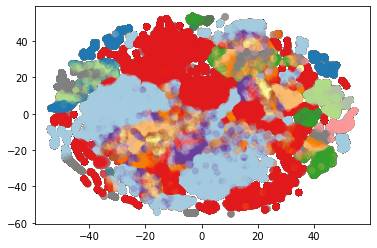

In [ ]:
from itertools import combinations
#clustering = DBSCAN(eps=3, min_samples=2)
#clustering.fit_predict(X)
feature_pairs = list(combinations(target_features, 2))
print (len(feature_pairs))
#feature_pairs = []
for pair in feature_pairs:
    feat_x = pair[0]
    feat_y = pair[1]
    #feature pair
    feature_pair = clean_metrics_df[list(pair)].to_numpy()
    feature_pair = np.nan_to_num(feature_pair, nan=0)
    clusterer = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=1100, prediction_data=True).fit(feature_pair)
    #print(len(clusterer.labels_))
    with open(f'data/BigQuery/clusters/feature_set_1/{feat_x}-{feat_y}_clusterer.pickle', 'wb') as handle:
        pickle.dump(clusterer, handle, protocol=pickle.HIGHEST_PROTOCOL)


    color_palette = sns.color_palette('Paired', 110000)
    #print(len(color_palette))

    cluster_colors = [color_palette[x] if x >= 0
                    else (0.5, 0.5, 0.5)
                    for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                            zip(cluster_colors, clusterer.probabilities_)]

    print (f"{feat_x}-{feat_y}_clusterer")
    print ("number of clusters", len(set(clusterer.labels_)))
    plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25) # modify projection
    plt.savefig(f"data/BigQuery/clusters/feature_set_1/plots/{feat_x}-{feat_y}_clusterer.jpg")

In [ ]:
#script is in df
#df to data set
class BigQueryDataset(Dataset):
    def __init__(self, script_df, clustering_result):
        self.script_df = script_df
        self.clustering_result = clustering_result
#can add other things here as well

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.script_df['count'][idx]
        label = self.clustering_result[idx] #this is where clustering result would go

        return image, label